In [1]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
import sys, os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import * # Ensure that dataloaders.py is saved in the same directory
from utils import *
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
import gc
import pandas as pd
import seaborn as sns

In [2]:
# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "gastrulation_erythroid"
cell_type_key = "combined_celltype"
model_name = "imVelo"

num_genes = 2000
nhead = 1 #original: 1
embedding_dim = 128*nhead# original: 128
num_encoder_layers = 1 #original: 1
num_bins = 50
batch_size = 128  # Batch size for training
epochs = 10  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1e-1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss

# Load data
adata = sc.read_h5ad("erythroid_pancreas.h5ad")

adata.obs[cell_type_key] = [str(cat) for cat in list(adata.obs[cell_type_key])]
adata.obs[cell_type_key] = pd.Series(adata.obs[cell_type_key], dtype="category")
unique_categories = adata.obs[cell_type_key].cat.categories
rgb_colors = sns.color_palette("tab20", len(unique_categories))
hex_colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in rgb_colors]
adata.uns[f"{cell_type_key}_colors"] = hex_colors
print(dataset_name)
adata.layers['counts_unspliced'] = adata.layers["unspliced"].copy()
adata.layers['counts_spliced'] = adata.layers["spliced"].copy()

# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=adata.shape[1]*2, latent_dim=latent_dim, 
                hidden_dim=hidden_dim, emb_dim = embedding_dim,
                nhead=nhead, num_encoder_layers=num_encoder_layers,
                num_genes=num_genes, num_bins=num_bins).to(device)
                
model.load_state_dict(torch.load('model_minmax.pth'))

# Ensure to call model.eval() if you're loading the model for inference to set the dropout and batch normalization layers to evaluation mode
model.eval()


gastrulation_erythroid


NETWORK(
  (embeddings): Embedding(4000, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=

In [3]:
_, _, full_data_loader = setup_dataloaders_binning(adata, 
                                                    batch_size=batch_size, 
                                                    num_genes=num_genes, 
                                                    num_bins=num_bins)

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"], dtype=np.float32)
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"], dtype=np.float32)
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2), dtype=np.float32)
adata.obsm["cell_embeddings"] = np.zeros((adata.shape[0], adata.shape[1] * 2), dtype=np.float32)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
model.eval()
with torch.no_grad():
    for batch_idx, (tokens, data, batch_indices) in enumerate(full_data_loader):
        print(f"Batch {batch_idx+1}/{len(full_data_loader)}")
        tokens = tokens.to(device)
        data = data.to(device)
        out_dic = model(tokens, data)

        # Store results and convert to numpy inside the loop to reduce peak memory usage
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].detach().cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].detach().cpu().numpy()
        adata.obsm["pred"][batch_indices] = out_dic["pred"].detach().cpu().numpy()
        adata.obsm["cell_embeddings"][batch_indices] = out_dic["cell_embeddings"].detach().cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Explicit memory cleanup
        del tokens, data, out_dic
        gc.collect()
        torch.cuda.empty_cache()  # If using CUDA

Batch 1/105
Batch 2/105
Batch 3/105
Batch 4/105
Batch 5/105
Batch 6/105
Batch 7/105
Batch 8/105
Batch 9/105
Batch 10/105
Batch 11/105
Batch 12/105
Batch 13/105
Batch 14/105
Batch 15/105
Batch 16/105
Batch 17/105
Batch 18/105
Batch 19/105
Batch 20/105
Batch 21/105
Batch 22/105
Batch 23/105
Batch 24/105
Batch 25/105
Batch 26/105
Batch 27/105
Batch 28/105
Batch 29/105
Batch 30/105
Batch 31/105
Batch 32/105
Batch 33/105
Batch 34/105
Batch 35/105
Batch 36/105
Batch 37/105
Batch 38/105
Batch 39/105
Batch 40/105
Batch 41/105
Batch 42/105
Batch 43/105
Batch 44/105
Batch 45/105
Batch 46/105
Batch 47/105
Batch 48/105
Batch 49/105
Batch 50/105
Batch 51/105
Batch 52/105
Batch 53/105
Batch 54/105
Batch 55/105
Batch 56/105
Batch 57/105
Batch 58/105
Batch 59/105
Batch 60/105
Batch 61/105
Batch 62/105
Batch 63/105
Batch 64/105
Batch 65/105
Batch 66/105
Batch 67/105
Batch 68/105
Batch 69/105
Batch 70/105
Batch 71/105
Batch 72/105
Batch 73/105
Batch 74/105
Batch 75/105
Batch 76/105
Batch 77/105
Batch 78

In [4]:
#adata.write_h5ad("final_adata.h5ad")

In [5]:
#adata = sc.read_h5ad("res_gastr.h5ad")

In [4]:
np.isnan(adata.layers["velocity_u"]).sum()

0

In [5]:
np.isnan(adata.layers["velocity"]).sum()

0

In [6]:
adata.obsm["MuMs"] = np.concatenate([adata.layers["Mu"], adata.layers["Ms"]], axis=1)
adata.obsm["velocity"] = np.concatenate([adata.layers["velocity_u"], adata.layers["velocity"]], axis=1)

In [20]:
adata.layers["velocity_u"][adata.obs["batch"] == "gastrulation"] *= -1
adata.layers["velocity"][adata.obs["batch"] == "gastrulation"] *= -1

In [13]:
adata.layers["velocity_u"][adata.obs["batch"] == "pancreas"] *= -1
adata.layers["velocity"][adata.obs["batch"] == "pancreas"] *= -1

In [8]:
adata.layers["velocity_u"] *= -1
adata.layers["velocity"] *= -1

computing velocity graph (using 1/24 cores)
    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


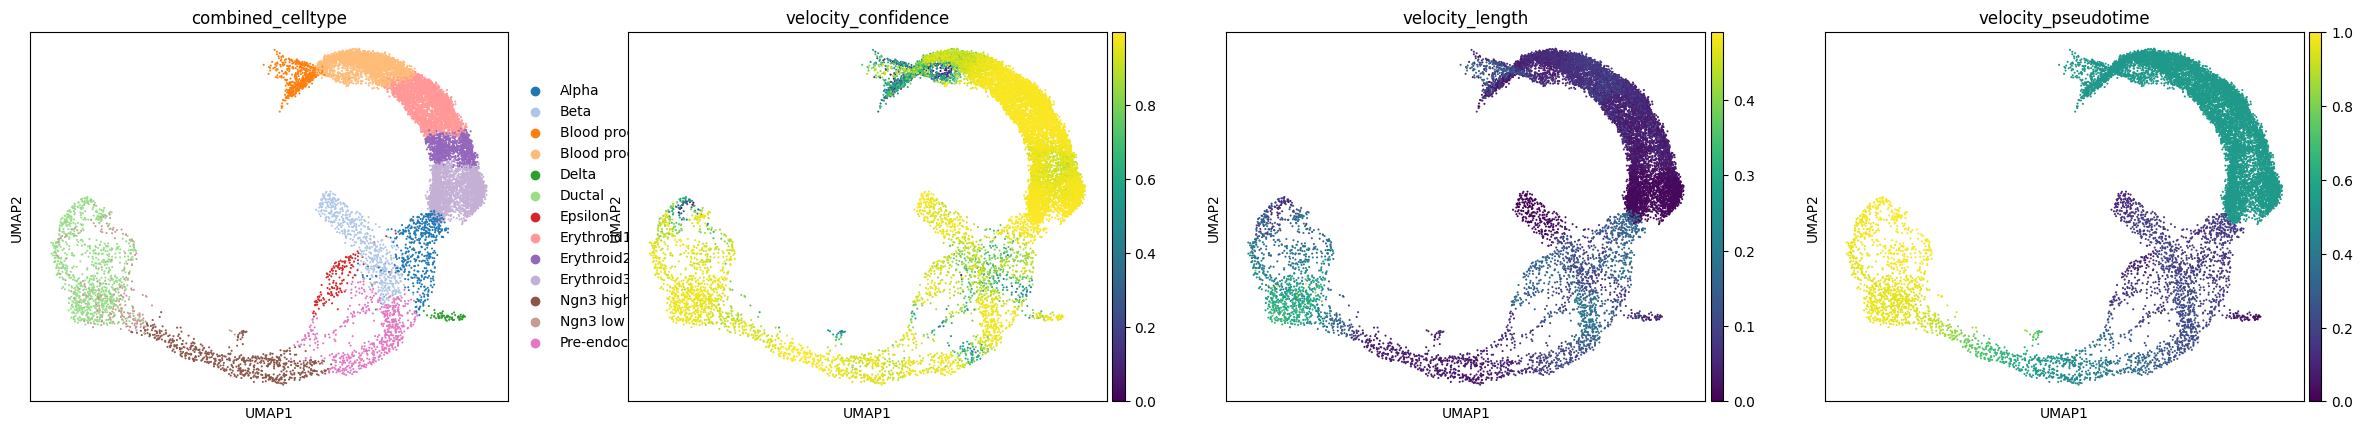

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


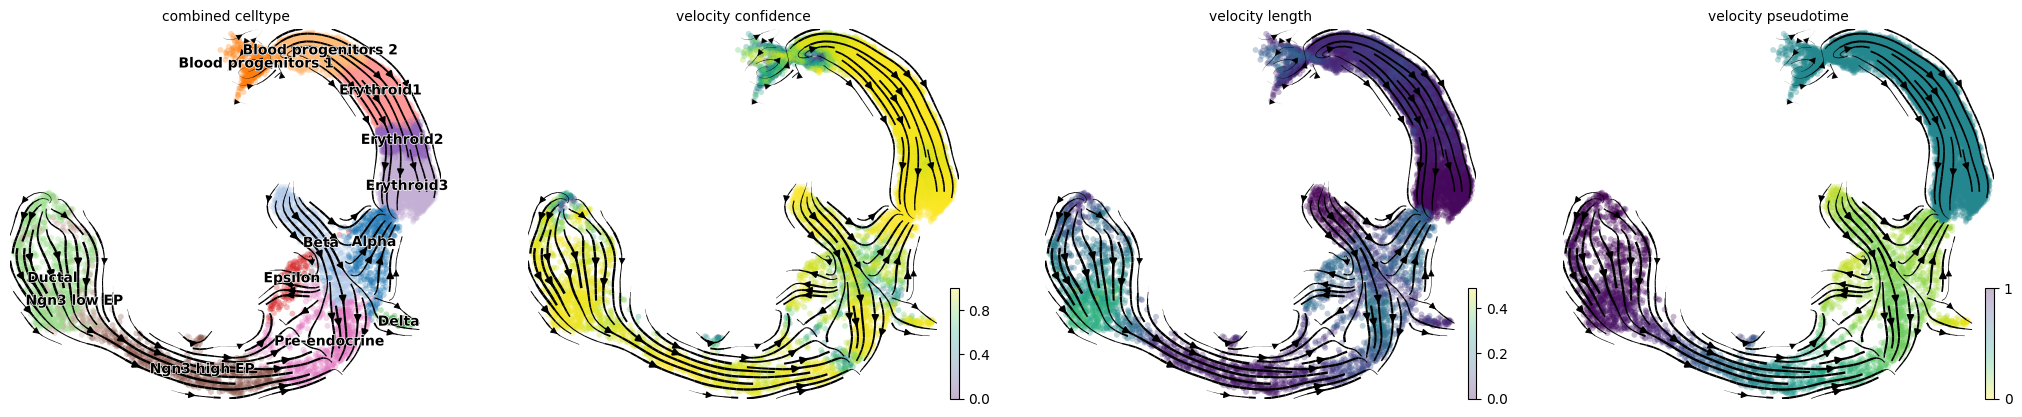

In [9]:
sc.pp.neighbors(adata)
#sc.tl.umap(adata)
scv.tl.velocity_graph(adata)
scv.tl.velocity_confidence(adata)
scv.tl.velocity_pseudotime(adata)
keys = ["combined_celltype", "velocity_confidence", "velocity_length", "velocity_pseudotime"]
sc.pl.umap(adata, color=keys)
scv.pl.velocity_embedding_stream(adata, color=keys, basis="umap")

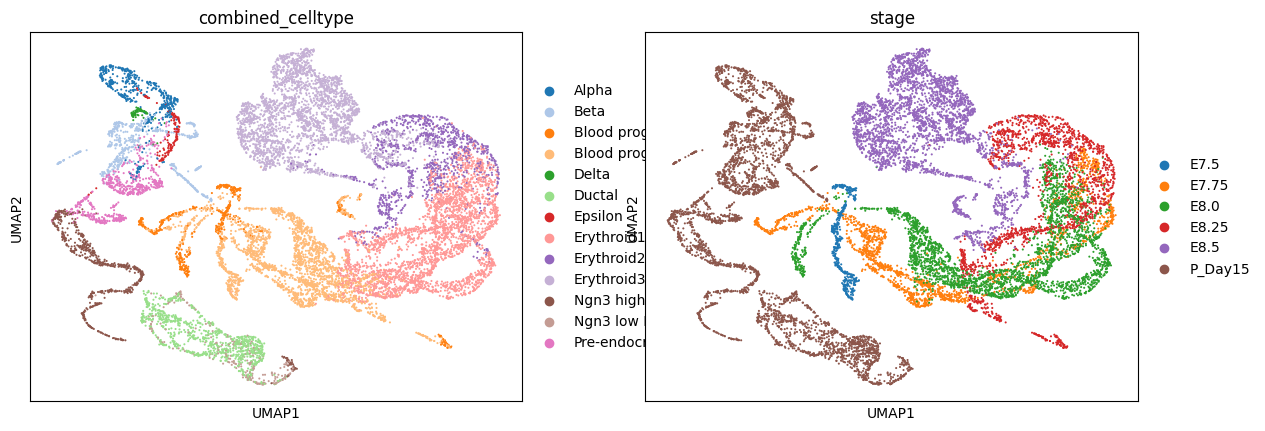

In [10]:
sc.pp.neighbors(adata,use_rep="velocity")
sc.tl.umap(adata)
keys = [cell_type_key, "stage"]
sc.pl.umap(adata, color=keys)

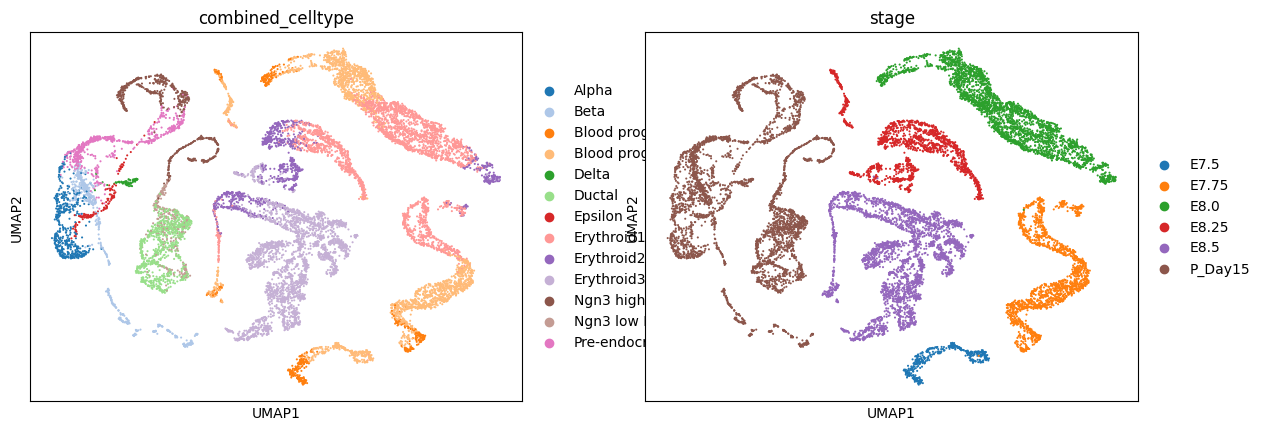

In [11]:
sc.pp.neighbors(adata, use_rep="cell_embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[cell_type_key, "stage"])

In [12]:
scv.tl.rank_velocity_genes(adata, groupby=cell_type_key)
pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])

ranking velocity genes
    finished (0:00:05) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Alpha,Beta,Blood progenitors 1,Blood progenitors 2,Delta,Ductal,Epsilon,Erythroid1,Erythroid2,Erythroid3,Ngn3 high EP,Ngn3 low EP,Pre-endocrine
0,Tmsb15l,Lrpprc,Por,Gypa,Pyy,Spp1,Ghrl,Hba-x,Hba-a2,Hbb-y,Dnm1,Ptprf,Prrg2
1,Auts2,Hmgn3,Hspa5,Tmem14c,Rbp4,Saraf,Acsl1,Hba-a1,Hba-x,Hemgn,Slc36a1,Cpq,Vdr
2,Gcg,Rab27a,Lgals1,Blvrb,Ppy,Slc35f5,Epha4,Hba-a2,Hba-a1,Slc4a1,Aplp1,Fam222a,Tm4sf4
3,Sphkap,Zdbf2,Tmem184b,Fth1,Auts2,Naga,Itfg1,Hbb-bh1,Hbb-bs,Sptbn1,Gck,Tle6,Cystm1
4,Rnf130,Bbx,Slc7a8,Psmb10,Ptprn,Rnf135,Npdc1,Alad,Slc4a1,Prtg,Ctsf,Serinc1,Akap17b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,H2-Ke6,Fscn1,Tubb6,Nupr1l,Fosb,Svip,Galns,Met,Mcoln3,Plekhg3,Ubl3,Fgd4,Pias1
96,Asap2,Plp2,Gng12,Raver1,Agl,Os9,Pgap1,G6pc2,Tspan12,Sel1l3,Gng4,Dap,Rgs17
97,Atat1,Dnajc12,Mras,Phactr1,Ccdc88a,Ctso,Lsr,Mapt,Ank3,Arhgap36,Fryl,Pdk2,Lhx1os
98,Cfap77,Syne1,Hip1r,Mapt,Agtrap,Jup,Nxph1,Spink1,Khdrbs3,Rtn1,Gabbr2,Hnf1aos1,Tmem38a


In [14]:
gene_names = ["Actb", "Hba-x", "Rap1b", "Gnas", "Rbfox3"]#, "Rpl18a"]

In [ ]:
for stage in adata.obs["stage"].unique():
    adata_tmp = adata[adata.obs["stage"] == stage].copy()
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    scv.pl.velocity_embedding_stream(adata_tmp, color=[cell_type_key], basis="umap")
    for gene_name in gene_names:
        plot_phase_plane(adata_tmp, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                    save_path="plots/plot1.png")

Plot saved to plots/plot1.png


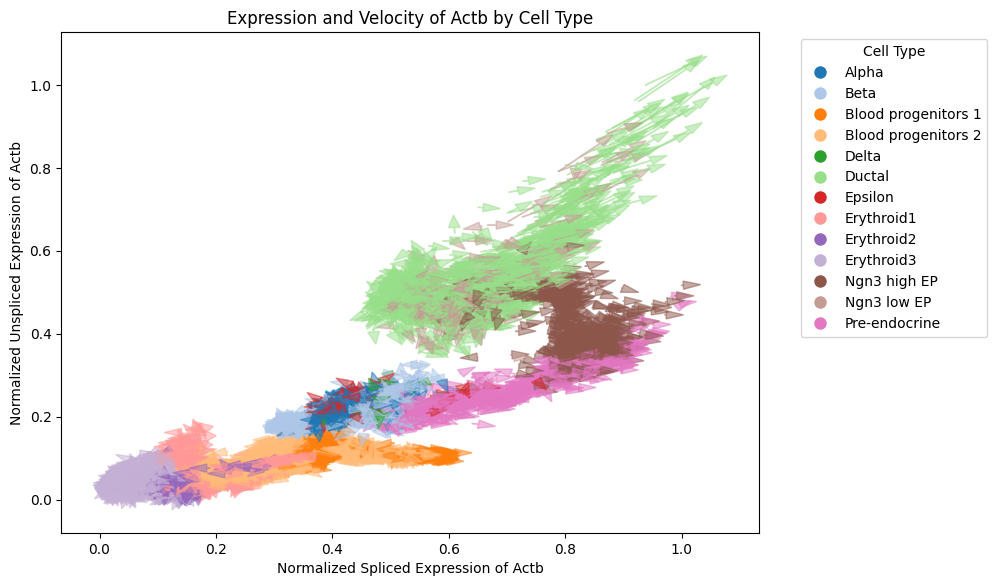

Plot saved to plots/plot1.png


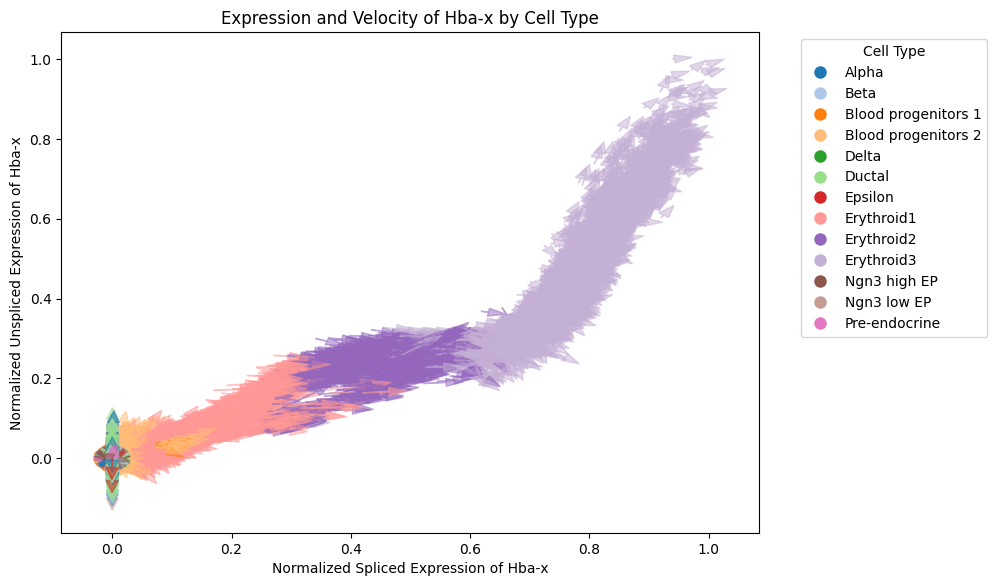

Plot saved to plots/plot1.png


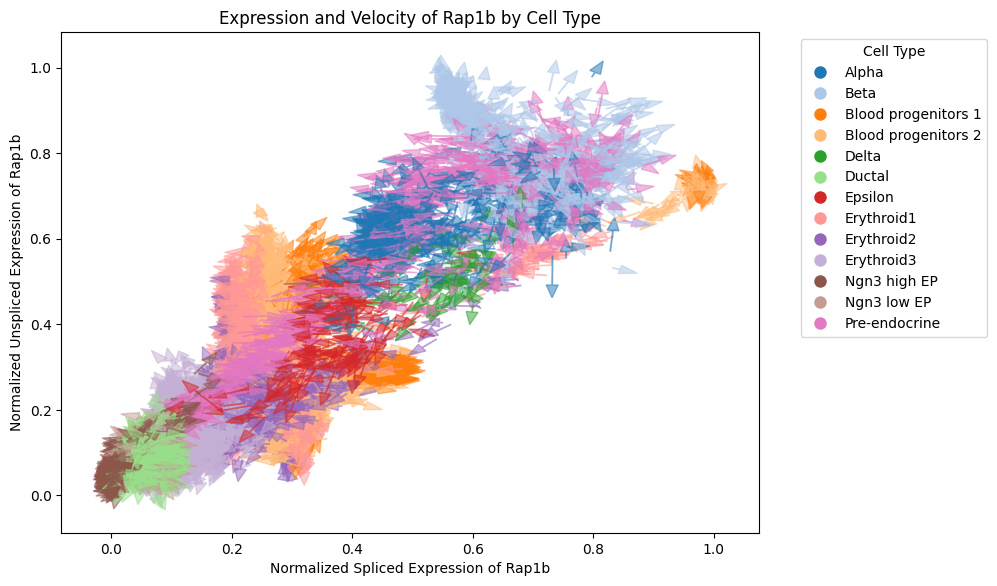

Plot saved to plots/plot1.png


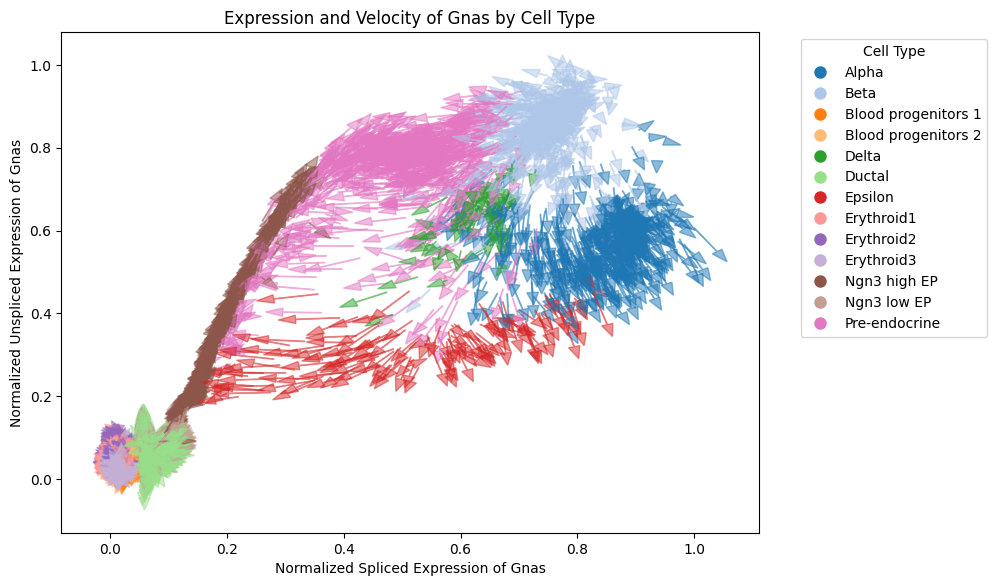

Plot saved to plots/plot1.png


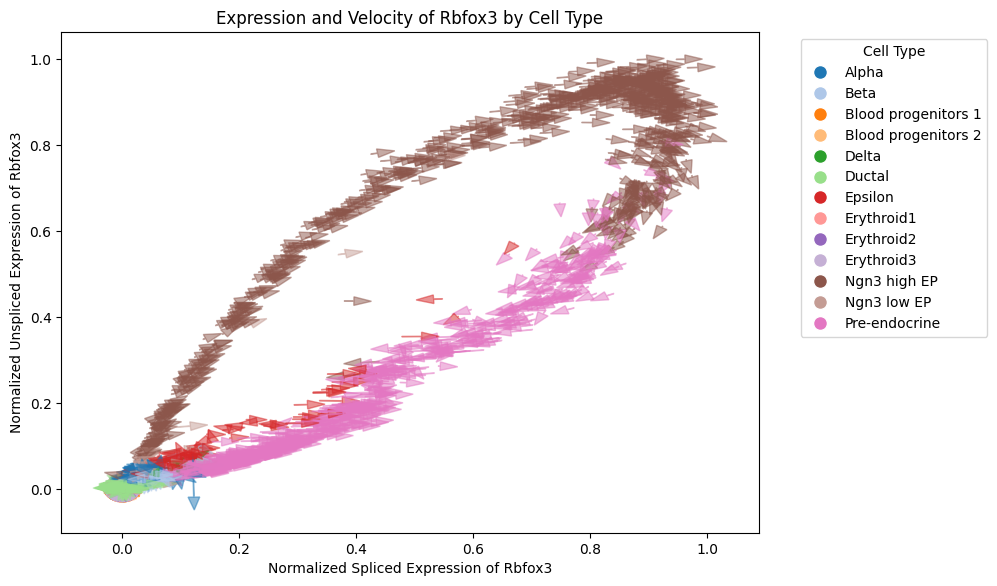

In [15]:
for gene_name in gene_names:
    plot_phase_plane(adata, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key,
                    save_path="plots/plot1.png")
    """plot_phase_plane(adata, gene_name, dataset_name, 11, 
                    u_scale=0.1, s_scale=0.1, cell_type_key="stage",
                    save_path="plots/plot1.png")
    """

In [ ]:
scv.datasets.